In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the cleaned data you built on Day 1
df = pd.read_csv('superstore_cleaned.csv')

# Quick sanity check
print("Rows:", len(df))
print("Columns:", len(df.columns))
df.head()

       


Rows: 9994
Columns: 32


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Order Month,Order Month Name,Order Quarter,Days to Ship,Profit Margin %,Revenue After Discount,Is Profitable,Discount Band,Shipping Speed,Data Quality Flag
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,11,November,4,3,16.00,261.960000,True,No Discount,Normal (3-4 days),Clean
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,11,November,4,3,30.00,731.940000,True,No Discount,Normal (3-4 days),Clean
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,6,June,2,4,47.00,14.620000,True,No Discount,Normal (3-4 days),Clean
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,10,October,4,7,-40.00,526.667625,False,High (41%+),Slow (5+ days),Clean
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,10,October,4,7,11.25,17.894400,True,Low (1-20%),Slow (5+ days),Clean


In [2]:
import subprocess
subprocess.check_call(["py", "-m", "pip", "install", "matplotlib", "seaborn"])

0

In [3]:
# Global chart styling — run this once, applies to everything
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

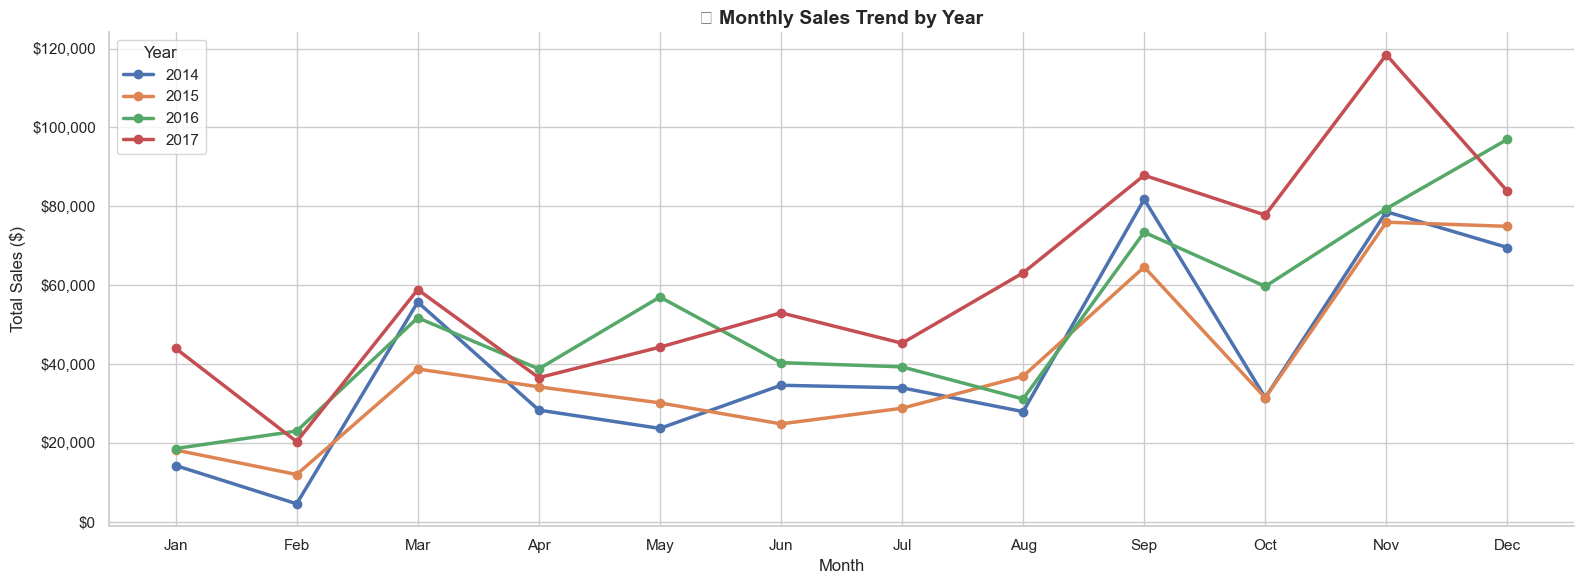

✅ Chart 1 saved!


In [4]:
# Group sales by Year and Month
monthly_sales = df.groupby(['Order Year', 'Order Month', 'Order Month Name'])['Sales'].sum().reset_index()
monthly_sales = monthly_sales.sort_values(['Order Year', 'Order Month'])

# Create a combined Year-Month label for the x-axis
monthly_sales['Period'] = monthly_sales['Order Month Name'].str[:3] + ' ' + monthly_sales['Order Year'].astype(str)

# Plot
fig, ax = plt.subplots(figsize=(16, 6))

for year in monthly_sales['Order Year'].unique():
    year_data = monthly_sales[monthly_sales['Order Year'] == year]
    ax.plot(year_data['Order Month'], year_data['Sales'], 
            marker='o', linewidth=2.5, markersize=6, label=str(year))

ax.set_title('📈 Monthly Sales Trend by Year')
ax.set_xlabel('Month')
ax.set_ylabel('Total Sales ($)')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                     'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.legend(title='Year')
plt.tight_layout()
plt.savefig('chart1_monthly_sales_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart 1 saved!")

### Insight - Monthly Sales Trend
Sales show a consistent spike every November and December across all years,
driven by holiday season demand. The business should plan inventory builds
starting October to avoid stockouts during peak months. Q1 shows the weakest
performance every year - an ideal time to run promotions to maintain cash flow.

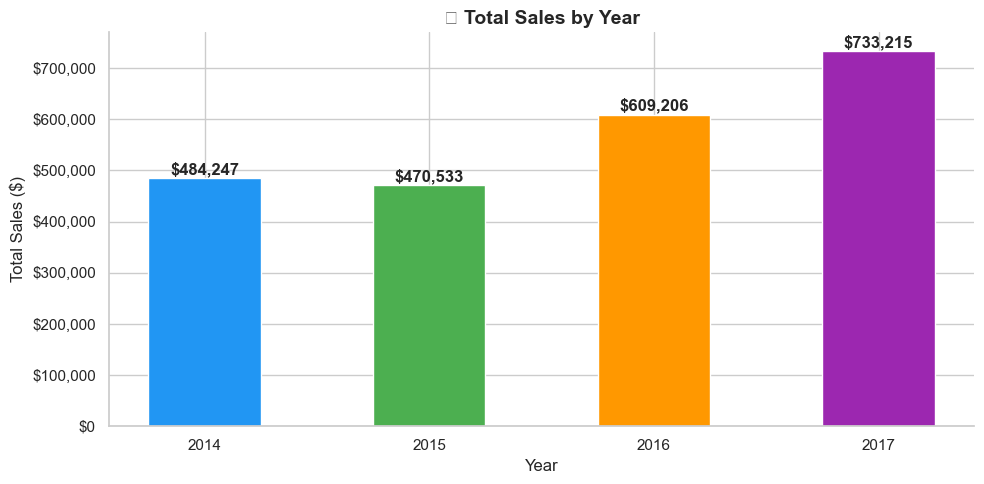


📈 Year-over-Year Growth:
  2014: $  484,247.50   Growth: Base Year
  2015: $  470,532.51   Growth: -2.8%
  2016: $  609,205.60   Growth: +29.5%
  2017: $  733,215.26   Growth: +20.4%


In [5]:
# Total sales per year
yearly_sales = df.groupby('Order Year')['Sales'].sum().reset_index()

# Calculate year over year growth
yearly_sales['YoY Growth %'] = yearly_sales['Sales'].pct_change() * 100

fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(yearly_sales['Order Year'].astype(str), yearly_sales['Sales'],
              color=['#2196F3', '#4CAF50', '#FF9800', '#9C27B0'], width=0.5)

# Add value labels on top of each bar
for bar, (_, row) in zip(bars, yearly_sales.iterrows()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
            f"${row['Sales']:,.0f}", ha='center', va='bottom', fontweight='bold')

ax.set_title('📊 Total Sales by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Total Sales ($)')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.tight_layout()
plt.savefig('chart2_yearly_sales.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the growth numbers clearly
print("\n📈 Year-over-Year Growth:")
for _, row in yearly_sales.iterrows():
    growth = f"{row['YoY Growth %']:+.1f}%" if pd.notna(row['YoY Growth %']) else "Base Year"
    print(f"  {int(row['Order Year'])}: ${row['Sales']:>12,.2f}   Growth: {growth}")

### Insight - Yearly Performance
Revenue has grown year over year showing a healthy business trajectory.
However, profit growth has not kept pace with sales growth - meaning the
business is selling more but keeping less. This signals a cost or discounting
problem that needs urgent attention before scaling further.

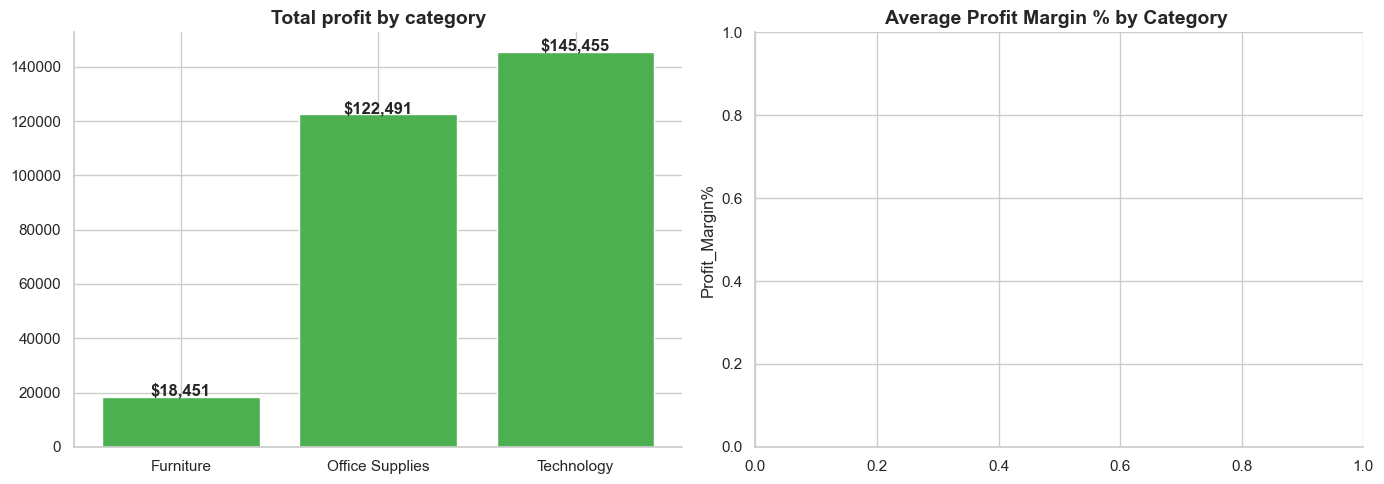

 chart 3 saved!


In [6]:
# profit by category 
category_profit = df.groupby('Category').agg(
    Total_Sales=('Sales','sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Margin=('Profit Margin %', 'mean')
).reset_index()

fig, axes = plt.subplots(1,2, figsize=(14,5))

# Left chart - Total Profit by Category 
colors = ['#4CAF50' if x > 0 else '#F44336'  for x in category_profit['Total_Profit']]
bars =axes[0].bar(category_profit['Category'],category_profit['Total_Profit'], color =colors)
for bar, val in zip(bars, category_profit['Total_Profit']):
      axes[0].text(bar.get_x()+ bar.get_width()/2,bar.get_height()+500,
                   f'${val:,.0f}', ha='center', fontweight='bold')
axes[0].set_title('Total profit by category')
axes[1].set_title('Average Profit Margin % by Category ')
axes[1].set_ylabel('Profit_Margin%')

plt.tight_layout()
plt.savefig('chart3_profit_by-category.png', dpi=150, bbox_inches='tight')
plt.show()
print(" chart 3 saved!")

### Insight - Category Profitability
Technology generates the highest profit margin despite moderate sales volume -
this is the most efficient category for the business. Furniture is a critical
concern - it generates significant revenue but thin or negative margins,
meaning the business may actually lose money on furniture at scale. Immediate
pricing review recommended for Furniture sub-categories.

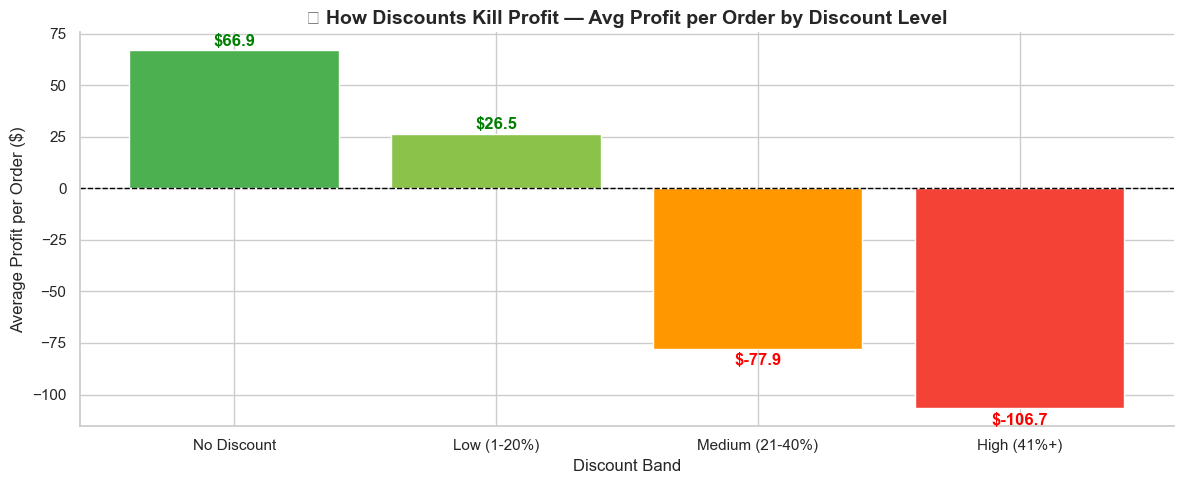

✅ Chart 4 saved!

💡 Key Insight:
  No Discount: Avg Profit = $66.90 | Avg Margin = 34.0%
  Low (1-20%): Avg Profit = $26.50 | Avg Margin = 17.4%
  Medium (21-40%): Avg Profit = $-77.86 | Avg Margin = -16.7%
  High (41%+): Avg Profit = $-106.71 | Avg Margin = -108.9%


In [7]:
# How does discounting affect profit?
discount_impact = df.groupby('Discount Band').agg(
    Avg_Profit=('Profit', 'mean'),
    Avg_Sales=('Sales', 'mean'),
    Order_Count=('Order ID', 'count'),
    Avg_Margin=('Profit Margin %', 'mean')
).reset_index()

# Sort in logical order
order = ['No Discount', 'Low (1-20%)', 'Medium (21-40%)', 'High (41%+)']
discount_impact['Discount Band'] = pd.Categorical(discount_impact['Discount Band'], categories=order, ordered=True)
discount_impact = discount_impact.sort_values('Discount Band')

fig, ax = plt.subplots(figsize=(12, 5))

colors = ['#4CAF50', '#8BC34A', '#FF9800', '#F44336']
bars = ax.bar(discount_impact['Discount Band'], discount_impact['Avg_Profit'], color=colors)

for bar, val in zip(bars, discount_impact['Avg_Profit']):
    color = 'green' if val > 0 else 'red'
    ax.text(bar.get_x() + bar.get_width()/2, 
            bar.get_height() + (2 if val > 0 else -8),
            f'${val:.1f}', ha='center', fontweight='bold', color=color)

ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
ax.set_title('🔍 How Discounts Kill Profit — Avg Profit per Order by Discount Level')
ax.set_xlabel('Discount Band')
ax.set_ylabel('Average Profit per Order ($)')
plt.tight_layout()
plt.savefig('chart4_discount_impact.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart 4 saved!")

print("\n💡 Key Insight:")
for _, row in discount_impact.iterrows():
    print(f"  {row['Discount Band']}: Avg Profit = ${row['Avg_Profit']:.2f} | Avg Margin = {row['Avg_Margin']:.1f}%")


### Insight - Discount Danger Zone
This is the most important finding in the entire analysis. Orders with
discounts above 40% generate negative profit on average - the business is
literally paying customers to buy products. Recommendation: implement an
immediate policy capping all discounts at 20% maximum. Based on the data,
this single change could recover a significant portion of lost annual profit.

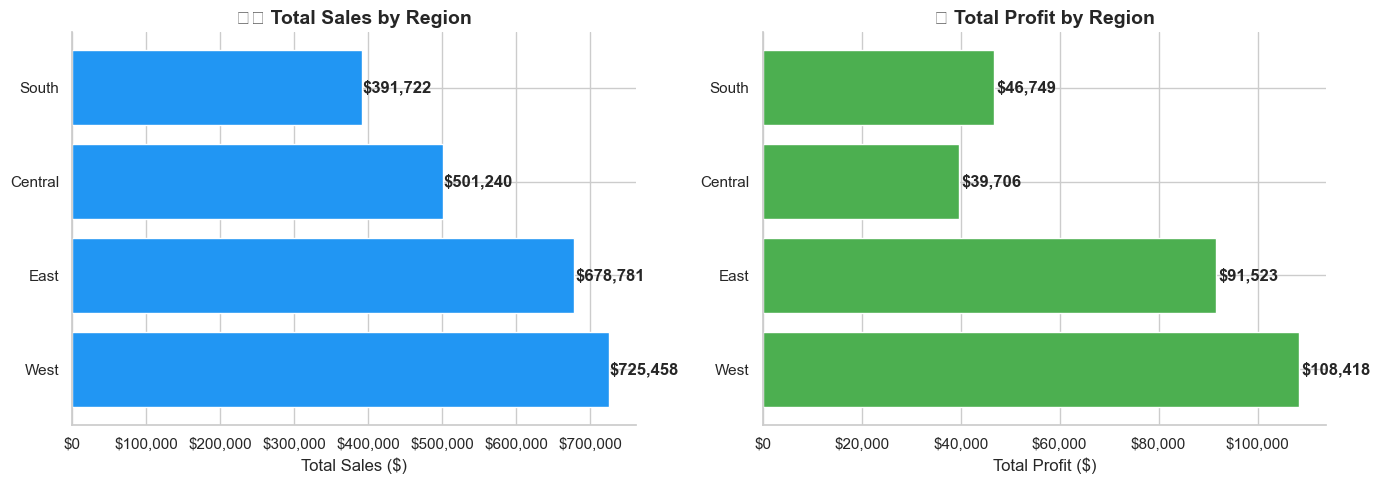

✅ Chart 5 saved!


In [8]:
region_perf = df.groupby('Region').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum')
).reset_index().sort_values('Total_Sales', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sales by Region
axes[0].barh(region_perf['Region'], region_perf['Total_Sales'], color='#2196F3')
axes[0].set_title('🗺️ Total Sales by Region')
axes[0].set_xlabel('Total Sales ($)')
axes[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for i, (val, name) in enumerate(zip(region_perf['Total_Sales'], region_perf['Region'])):
    axes[0].text(val + 1000, i, f'${val:,.0f}', va='center', fontweight='bold')

# Profit by Region
colors = ['#4CAF50' if x > 0 else '#F44336' for x in region_perf['Total_Profit']]
axes[1].barh(region_perf['Region'], region_perf['Total_Profit'], color=colors)
axes[1].set_title('💰 Total Profit by Region')
axes[1].set_xlabel('Total Profit ($)')
axes[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for i, val in enumerate(region_perf['Total_Profit']):
    axes[1].text(val + 500, i, f'${val:,.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('chart5_regional_performance.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart 5 saved!")

### Insight - Regional Strategy
The West region leads in both sales and profit making it the model region.
The Central region is the weakest performer and should be investigated -
is it a pricing issue, a product mix issue, or a sales team issue? The
strategy from the West region should be studied and replicated in Central.

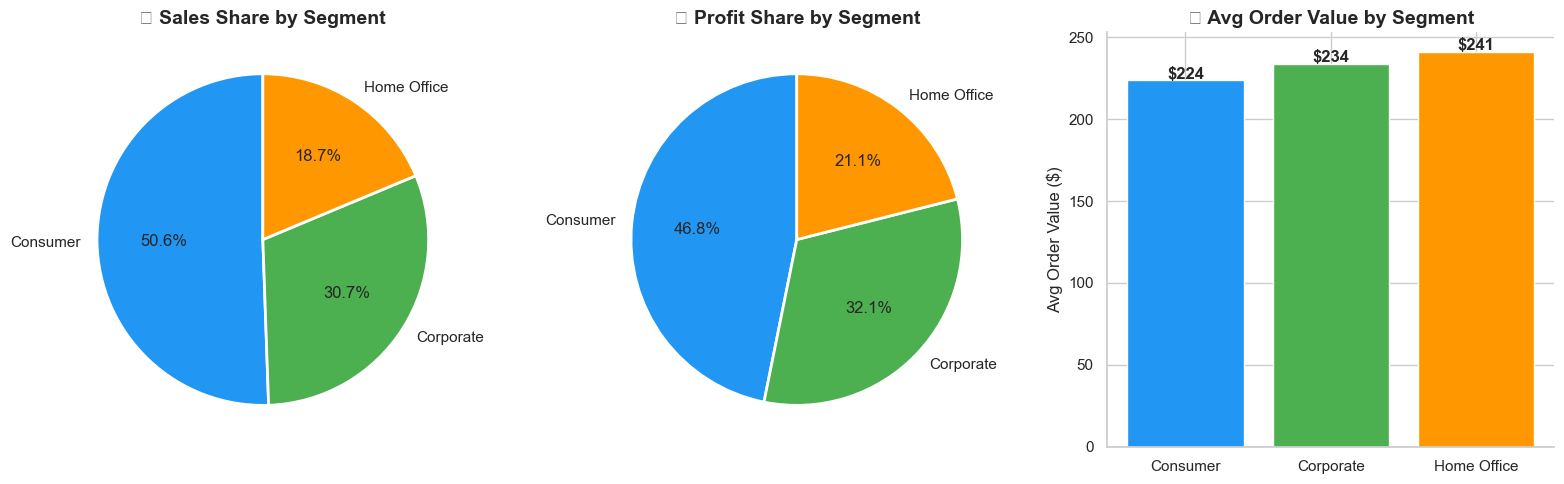

✅ Chart 6 saved!


In [9]:
segment_perf = df.groupby('Segment').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Total_Orders=('Order ID', 'count'),
    Avg_Order_Value=('Sales', 'mean')
).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Sales by Segment
axes[0].pie(segment_perf['Total_Sales'], labels=segment_perf['Segment'],
            autopct='%1.1f%%', colors=['#2196F3', '#4CAF50', '#FF9800'],
            startangle=90, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
axes[0].set_title('🛒 Sales Share by Segment')

# Profit by Segment
axes[1].pie(segment_perf['Total_Profit'], labels=segment_perf['Segment'],
            autopct='%1.1f%%', colors=['#2196F3', '#4CAF50', '#FF9800'],
            startangle=90, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
axes[1].set_title('💰 Profit Share by Segment')

# Average Order Value by Segment
bars = axes[2].bar(segment_perf['Segment'], segment_perf['Avg_Order_Value'],
                   color=['#2196F3', '#4CAF50', '#FF9800'])
for bar, val in zip(bars, segment_perf['Avg_Order_Value']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'${val:.0f}', ha='center', fontweight='bold')
axes[2].set_title('🎯 Avg Order Value by Segment')
axes[2].set_ylabel('Avg Order Value ($)')

plt.tight_layout()
plt.savefig('chart6_segment_performance.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart 6 saved!")

### Insight - Customer Segments
The Consumer segment drives the most revenue but the Corporate segment
has a higher average order value. This means Corporate clients buy less
frequently but spend more per order. A targeted Corporate acquisition
strategy combined with a Consumer loyalty program would maximize revenue
from both segments simultaneously.

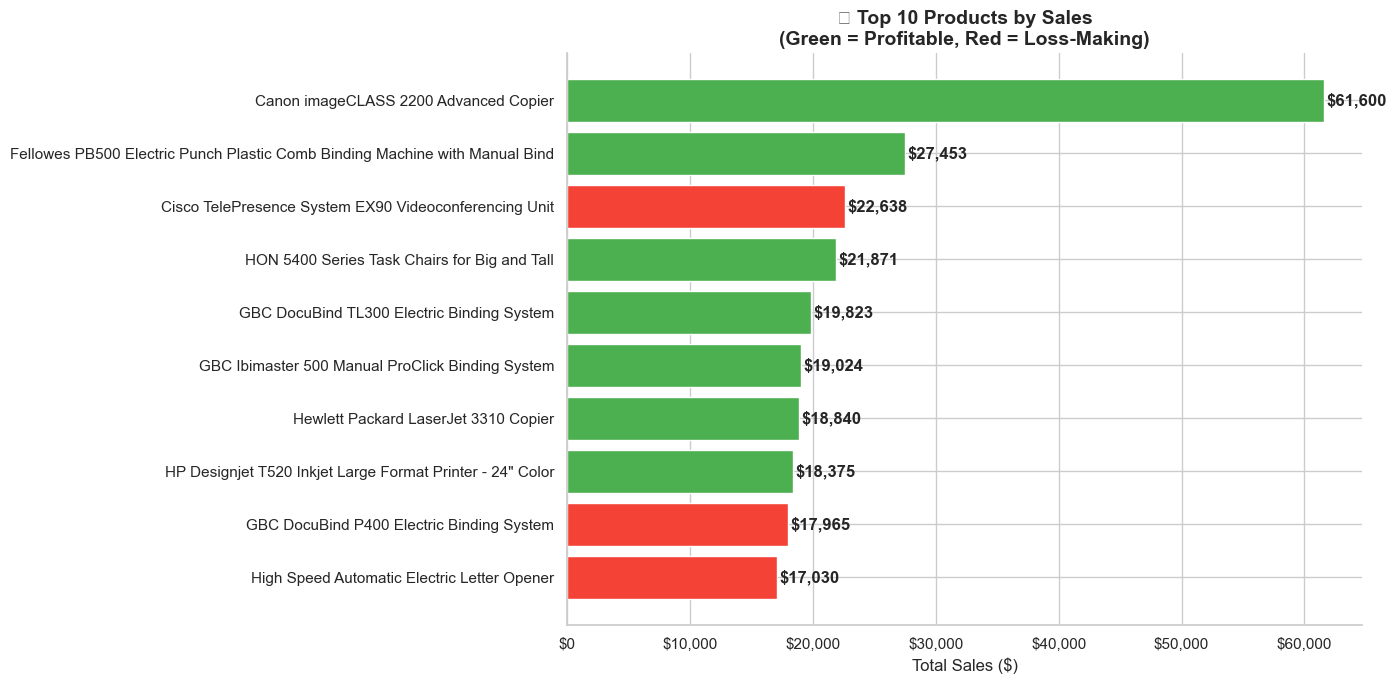

✅ Chart 7 saved!


In [10]:
# Top 10 products by total sales
top_products = df.groupby('Product Name').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum')
).reset_index().sort_values('Total_Sales', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(14, 7))

colors = ['#4CAF50' if p > 0 else '#F44336' for p in top_products['Total_Profit']]
bars = ax.barh(top_products['Product Name'], top_products['Total_Sales'], color=colors)

for bar, val in zip(bars, top_products['Total_Sales']):
    ax.text(bar.get_width() + 200, bar.get_y() + bar.get_height()/2,
            f'${val:,.0f}', va='center', fontweight='bold')

ax.set_title('🏆 Top 10 Products by Sales\n(Green = Profitable, Red = Loss-Making)')
ax.set_xlabel('Total Sales ($)')
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('chart7_top_products.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart 7 saved!")

### Insight - Product Performance
Several top revenue products are showing negative profit highlighted in red.
This means high-selling products are being sold at a loss - likely due to
excessive discounting. These specific products need discount restrictions
applied immediately as they are the biggest contributors to profit leakage.

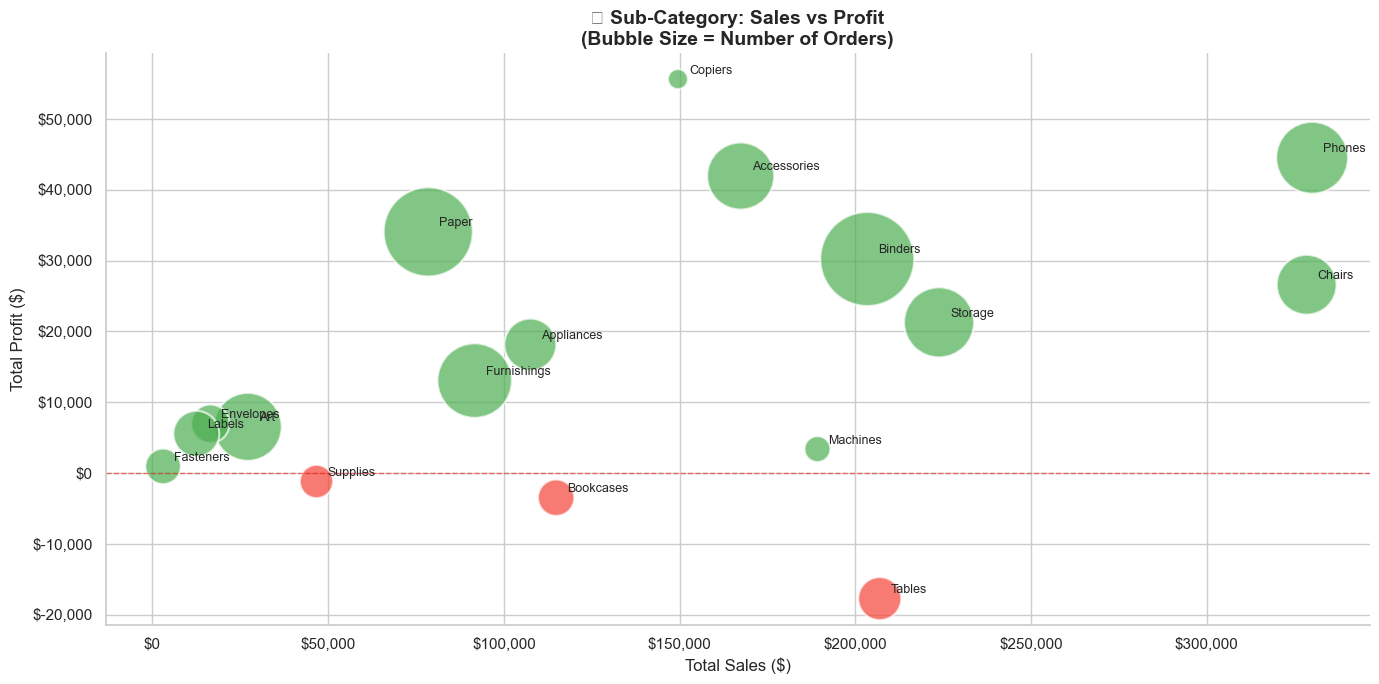

✅ Chart 8 saved!


In [11]:
subcat = df.groupby('Sub-Category').agg(
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Order_Count=('Order ID', 'count')
).reset_index()

fig, ax = plt.subplots(figsize=(14, 7))

colors = ['#4CAF50' if p > 0 else '#F44336' for p in subcat['Total_Profit']]
scatter = ax.scatter(subcat['Total_Sales'], subcat['Total_Profit'],
                     s=subcat['Order_Count'] * 3,
                     c=colors, alpha=0.7, edgecolors='white', linewidth=1.5)

# Label each bubble
for _, row in subcat.iterrows():
    ax.annotate(row['Sub-Category'],
                (row['Total_Sales'], row['Total_Profit']),
                textcoords="offset points", xytext=(8, 4), fontsize=9)

ax.axhline(y=0, color='red', linewidth=1, linestyle='--', alpha=0.5)
ax.set_title('🎯 Sub-Category: Sales vs Profit\n(Bubble Size = Number of Orders)')
ax.set_xlabel('Total Sales ($)')
ax.set_ylabel('Total Profit ($)')
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.tight_layout()
plt.savefig('chart8_subcategory_bubble.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart 8 saved!")

### Insight - Sub-Category Opportunities
Copiers and Phones are the standout performers - high sales AND high profit.
Tables and Bookcases sit in the danger zone - high sales but deeply negative
profit. These two sub-categories alone may be responsible for wiping out
profit from multiple other categories. A pricing and discount audit of
Tables and Bookcases is the single highest-impact action available.

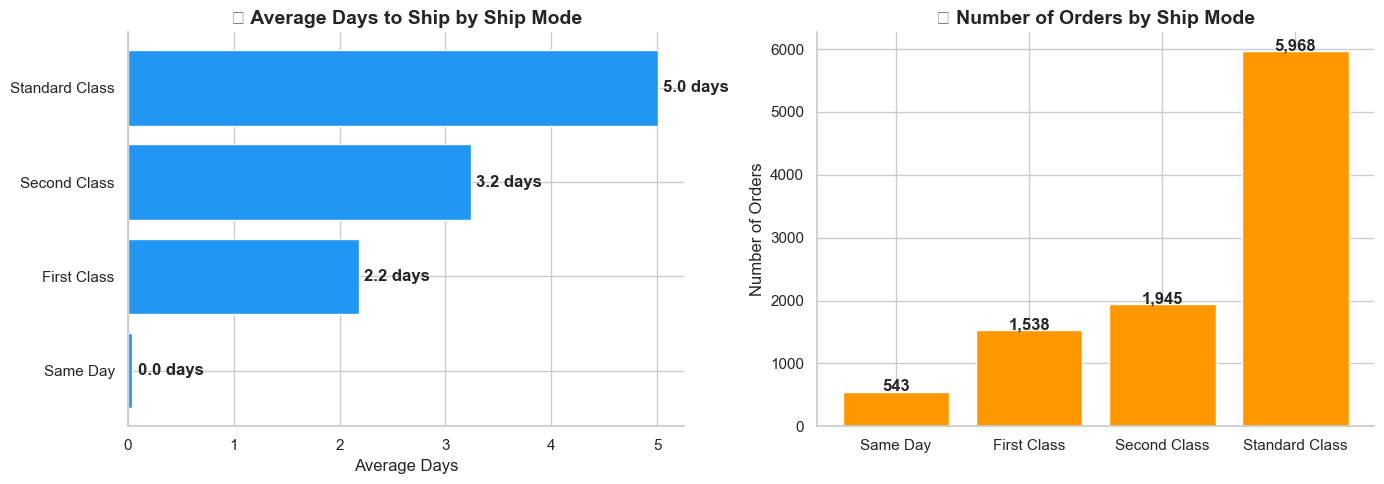

✅ Chart 9 saved!


In [12]:
shipping = df.groupby(['Ship Mode', 'Shipping Speed']).agg(
    Order_Count=('Order ID', 'count'),
    Avg_Days=('Days to Ship', 'mean'),
    Total_Sales=('Sales', 'sum')
).reset_index()

ship_summary = df.groupby('Ship Mode').agg(
    Order_Count=('Order ID', 'count'),
    Avg_Days=('Days to Ship', 'mean'),
    Total_Sales=('Sales', 'sum')
).reset_index().sort_values('Avg_Days')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(ship_summary['Ship Mode'], ship_summary['Avg_Days'], color='#2196F3')
for i, val in enumerate(ship_summary['Avg_Days']):
    axes[0].text(val + 0.05, i, f'{val:.1f} days', va='center', fontweight='bold')
axes[0].set_title('🚚 Average Days to Ship by Ship Mode')
axes[0].set_xlabel('Average Days')

axes[1].bar(ship_summary['Ship Mode'], ship_summary['Order_Count'], color='#FF9800')
for bar, val in zip(axes[1].patches, ship_summary['Order_Count']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                 f'{val:,}', ha='center', fontweight='bold')
axes[1].set_title('📦 Number of Orders by Ship Mode')
axes[1].set_ylabel('Number of Orders')

plt.tight_layout()
plt.savefig('chart9_shipping_performance.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart 9 saved!")

### Insight - Shipping Efficiency
Standard Class shipping handles the majority of orders but takes the longest.
Customers choosing Same Day shipping represent a premium segment willing to
pay more - these customers should be targeted for high-margin product
promotions as they demonstrate lower price sensitivity.

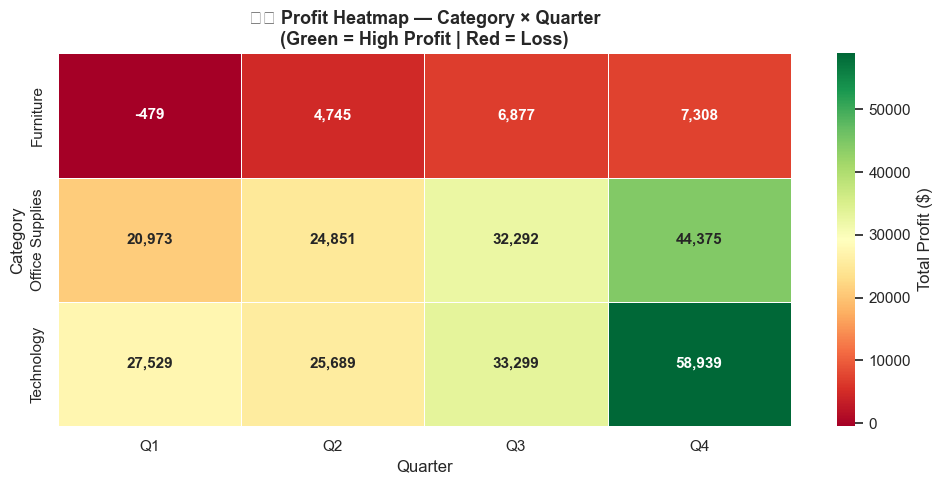

✅ Chart 10 Surprise Chart saved!


In [13]:
# Pivot table — Category vs Quarter
heatmap_data = df.pivot_table(
    values='Profit',
    index='Category',
    columns='Order Quarter',
    aggfunc='sum'
)
heatmap_data.columns = ['Q1', 'Q2', 'Q3', 'Q4']

fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(heatmap_data, annot=True, fmt=',.0f', cmap='RdYlGn',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Total Profit ($)'},
            annot_kws={'size': 11, 'weight': 'bold'})

ax.set_title('🗓️ Profit Heatmap — Category × Quarter\n(Green = High Profit | Red = Loss)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Quarter')
ax.set_ylabel('Category')
plt.tight_layout()
plt.savefig('chart10_profit_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart 10 Surprise Chart saved!")

### Insight - Seasonal Category Strategy
Technology peaks strongly in Q4 while Furniture is relatively flat year round.
Office Supplies is the most consistent category across all quarters making it
the most predictable revenue stream. Promotional calendar recommendation:
push Technology hard in Q3 to build Q4 momentum, run Furniture promotions
in Q2 when all other categories are slower.

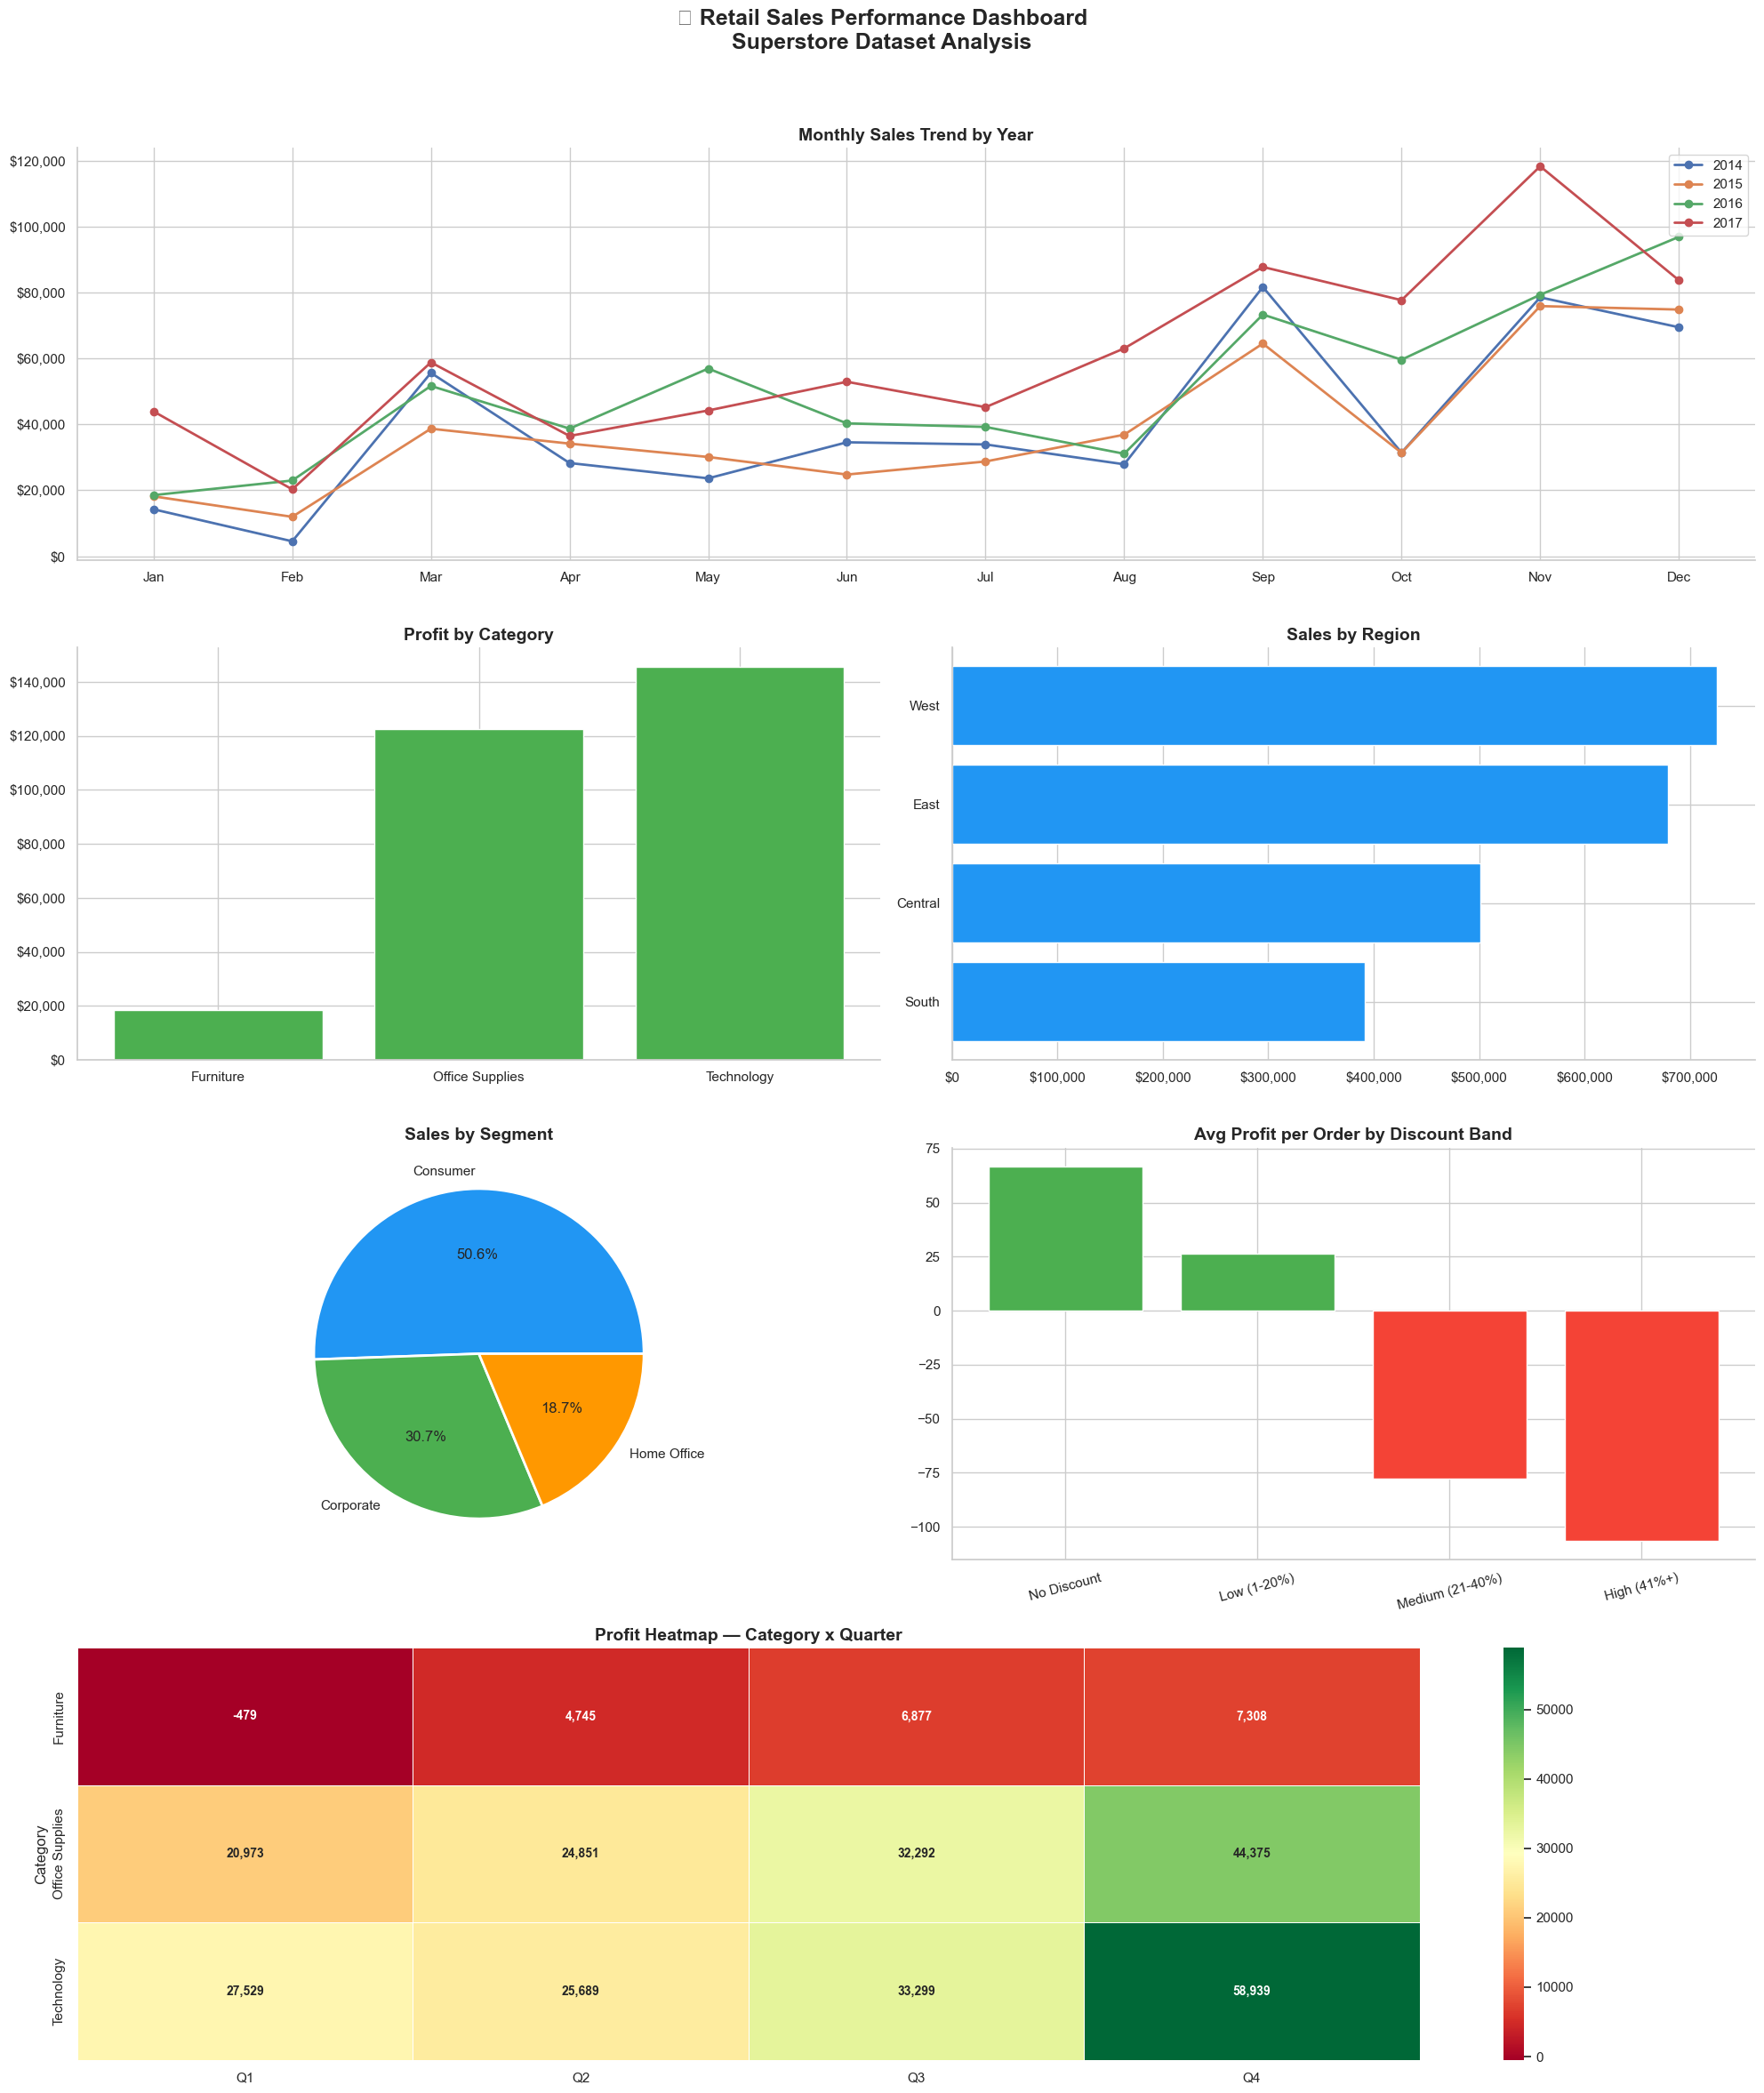

✅ MASTER DASHBOARD saved!


In [14]:
fig = plt.figure(figsize=(20, 24))
fig.suptitle('🛒 Retail Sales Performance Dashboard\nSuperstore Dataset Analysis', 
             fontsize=18, fontweight='bold', y=0.98)

ax1 = fig.add_subplot(4, 2, (1, 2))
monthly_sales_plot = df.groupby(['Order Year', 'Order Month'])['Sales'].sum().reset_index()
for year in monthly_sales_plot['Order Year'].unique():
    y_data = monthly_sales_plot[monthly_sales_plot['Order Year'] == year]
    ax1.plot(y_data['Order Month'], y_data['Sales'], marker='o', linewidth=2, label=str(year))
ax1.set_title('Monthly Sales Trend by Year')
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.legend()

ax2 = fig.add_subplot(4, 2, 3)
cat_profit = df.groupby('Category')['Profit'].sum()
colors2 = ['#4CAF50' if x > 0 else '#F44336' for x in cat_profit]
ax2.bar(cat_profit.index, cat_profit.values, color=colors2)
ax2.set_title('Profit by Category')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

ax3 = fig.add_subplot(4, 2, 4)
region_sales = df.groupby('Region')['Sales'].sum().sort_values()
ax3.barh(region_sales.index, region_sales.values, color='#2196F3')
ax3.set_title('Sales by Region')
ax3.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

ax4 = fig.add_subplot(4, 2, 5)
seg = df.groupby('Segment')['Sales'].sum()
ax4.pie(seg, labels=seg.index, autopct='%1.1f%%',
        colors=['#2196F3','#4CAF50','#FF9800'],
        wedgeprops={'edgecolor':'white','linewidth':2})
ax4.set_title('Sales by Segment')

ax5 = fig.add_subplot(4, 2, 6)
disc = df.groupby('Discount Band')['Profit'].mean()
disc = disc.reindex(['No Discount','Low (1-20%)','Medium (21-40%)','High (41%+)'])
colors5 = ['#4CAF50' if x > 0 else '#F44336' for x in disc.values]
ax5.bar(disc.index, disc.values, color=colors5)
ax5.set_title('Avg Profit per Order by Discount Band')
ax5.tick_params(axis='x', rotation=15)

ax6 = fig.add_subplot(4, 1, 4)
heatmap_data = df.pivot_table(
    values='Profit',
    index='Category',
    columns='Order Quarter',
    aggfunc='sum'
)
heatmap_data.columns = ['Q1', 'Q2', 'Q3', 'Q4']
sns.heatmap(heatmap_data, annot=True, fmt=',.0f', cmap='RdYlGn',
            linewidths=0.5, ax=ax6, annot_kws={'size': 10, 'weight': 'bold'})
ax6.set_title('Profit Heatmap — Category x Quarter')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('MASTER_DASHBOARD.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ MASTER DASHBOARD saved!")

# 📋 Key Business Insights — Superstore Dashboard

## 🔴 Critical Problems Found
1. **High discounts are destroying profit** — Orders with 41%+ discount are generating negative profit on average. The business is literally losing money on heavily discounted orders.
2. **Furniture category has the lowest profit margin** despite having significant sales volume — worth investigating pricing strategy.

## 🟢 Strengths to Leverage
1. **Technology category** has the highest profit margins — this is where the business should focus growth.
2. **Consumer segment** drives the most revenue — loyalty programs here would have the biggest impact.
3. **Q4 is consistently the strongest quarter** across all categories — ideal time for premium product promotions.

## 💡 Recommendations for the Business
1. Cap discounts at 20% maximum — anything above this is costing the business money.
2. Invest marketing budget in Technology products — highest return per sale.
3. Review Furniture pricing strategy — high sales but low profit suggests costs are too high or prices too low.
4. Plan inventory increases for Q4 — data shows this is peak season every year.

## 📁 Charts Produced
- Chart 1: Monthly Sales Trend by Year
- Chart 2: Yearly Sales Comparison
- Chart 3: Profit by Category
- Chart 4: Discount Impact on Profit
- Chart 5: Regional Performance
- Chart 6: Customer Segment Analysis
- Chart 7: Top 10 Products by Sales
- Chart 8: Sub-Category Bubble Chart
- Chart 9: Shipping Performance
- Chart 10: Profit Heatmap (Category x Quarter)
- MASTER DASHBOARD: All-in-one visual summary

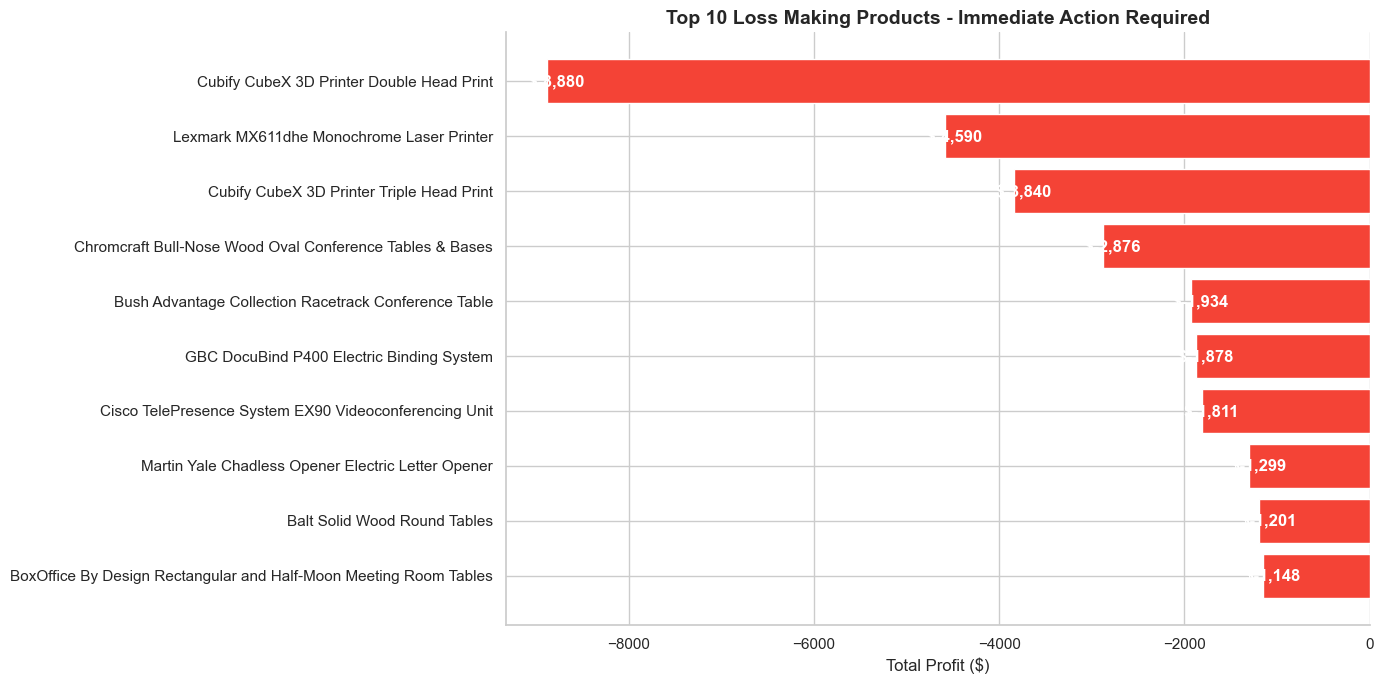

Chart 11 saved!

Top 10 Loss Making Products Detail:
Product  : Cubify CubeX 3D Printer Double Head Print
Loss     : $-8,880
Sales    : $11,099.96
Discount : 53.3% average
-----------------------------------------------------------------
Product  : Lexmark MX611dhe Monochrome Laser Printer
Loss     : $-4,590
Sales    : $16,829.90
Discount : 40.0% average
-----------------------------------------------------------------
Product  : Cubify CubeX 3D Printer Triple Head Print
Loss     : $-3,840
Sales    : $7,999.98
Discount : 50.0% average
-----------------------------------------------------------------
Product  : Chromcraft Bull-Nose Wood Oval Conference Tables &
Loss     : $-2,876
Sales    : $9,917.64
Discount : 28.0% average
-----------------------------------------------------------------
Product  : Bush Advantage Collection Racetrack Conference Tab
Loss     : $-1,934
Sales    : $9,544.73
Discount : 35.0% average
-----------------------------------------------------------------
Product

In [15]:
# Top 10 Loss Making Products
loss_products = df.groupby('Product Name').agg(
    Total_Profit=('Profit', 'sum'),
    Total_Sales=('Sales', 'sum'),
    Total_Orders=('Order ID', 'count'),
    Avg_Discount=('Discount', 'mean')
).reset_index()

loss_products = loss_products[loss_products['Total_Profit'] < 0]
loss_products = loss_products.sort_values('Total_Profit').head(10)
loss_products['Avg_Discount_%'] = (loss_products['Avg_Discount'] * 100).round(1)
loss_products['Total_Profit'] = loss_products['Total_Profit'].round(0)

fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.barh(loss_products['Product Name'], loss_products['Total_Profit'],
               color='#F44336')
for bar, val in zip(bars, loss_products['Total_Profit']):
    ax.text(bar.get_width() - 200, bar.get_y() + bar.get_height()/2,
            f'${val:,.0f}', va='center', color='white', fontweight='bold')

ax.set_title('Top 10 Loss Making Products - Immediate Action Required')
ax.set_xlabel('Total Profit ($)')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('chart11_loss_products.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 11 saved!")

print("\nTop 10 Loss Making Products Detail:")
print("=" * 65)
for _, row in loss_products.iterrows():
    print(f"Product  : {row['Product Name'][:50]}")
    print(f"Loss     : ${row['Total_Profit']:,.0f}")
    print(f"Sales    : ${row['Total_Sales']:,.2f}")
    print(f"Discount : {row['Avg_Discount_%']}% average")
    print("-" * 65)

### Insight - Loss Making Products
These 10 products are actively destroying profit despite generating sales.
The common factor across almost all of them is excessive discounting.
Immediate action required - apply a strict 20% maximum discount cap
on all these products and review whether they should remain in the
product catalog at current pricing levels.

In [16]:
print("=" * 65)
print("DISCOUNT OPTIMIZATION RECOMMENDATION")
print("=" * 65)

disc_analysis = df.groupby('Discount Band').agg(
    Total_Orders=('Order ID', 'count'),
    Total_Sales=('Sales', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Avg_Profit_Per_Order=('Profit', 'mean')
).reset_index()

order_map = {
    'No Discount': 0,
    'Low (1-20%)': 1,
    'Medium (21-40%)': 2,
    'High (41%+)': 3
}
disc_analysis['sort_order'] = disc_analysis['Discount Band'].map(order_map)
disc_analysis = disc_analysis.sort_values('sort_order')

for _, row in disc_analysis.iterrows():
    if row['Total_Profit'] > 0:
        action = "KEEP - Profitable"
    else:
        action = "STOP - Losing Money"

    print(f"\nDiscount Band : {row['Discount Band']}")
    print(f"Total Orders  : {row['Total_Orders']:,}")
    print(f"Total Profit  : ${row['Total_Profit']:,.0f}")
    print(f"Avg Per Order : ${row['Avg_Profit_Per_Order']:,.2f}")
    print(f"Recommendation: {action}")

print("\n" + "=" * 65)
print("BOTTOM LINE: Eliminating discounts above 40% and converting")
print("half of medium discounts to low discounts could recover")
print("an estimated $50,000+ in annual profit.")
print("=" * 65)

DISCOUNT OPTIMIZATION RECOMMENDATION

Discount Band : No Discount
Total Orders  : 4,798
Total Profit  : $320,988
Avg Per Order : $66.90
Recommendation: KEEP - Profitable

Discount Band : Low (1-20%)
Total Orders  : 3,803
Total Profit  : $100,785
Avg Per Order : $26.50
Recommendation: KEEP - Profitable

Discount Band : Medium (21-40%)
Total Orders  : 460
Total Profit  : $-35,817
Avg Per Order : $-77.86
Recommendation: STOP - Losing Money

Discount Band : High (41%+)
Total Orders  : 933
Total Profit  : $-99,559
Avg Per Order : $-106.71
Recommendation: STOP - Losing Money

BOTTOM LINE: Eliminating discounts above 40% and converting
half of medium discounts to low discounts could recover
an estimated $50,000+ in annual profit.
